In [1]:
##############################################################################
# File:                 MIDAS_Wolverines_PHMAP2023_Challenge
# Author:               Joseph Cohen
# Contact:              cohenyo@umich.edu
# Date executed:        August 30, 2023
#
# Description:  
#   - This is the code associated with the PHM Asia-Pacific 2023 Data Challenge and poster.
#
# Data Inputs:
#   - labels.csv
#   - Case1.csv through Case177.csv compiled into dataset/training/data_array.npy (training)
#   - Case178.csv through Case223.csv compiled into dataset/testing/data_array.npy (testing)
#
# Methods:
#   - Approach uses sparse models (LASSO, L1-penalized Logistic Regression) + wavelet features
#   - Resulted in a high score of 92.98% and 8th place in the international competition
#
# Operating System:
#   - Windows or Mac
#
# Software Version:
#   - Python 3.10.9
#
# Libraries/Dependencies: 
#   - pandas: Version 1.4.2
#   - numpy: Version 1.23.5
#   - matplotlib: Version 3.7.1
#   - seaborn: Version 0.11.2
#   - scikit-learn: Version 1.2.1
#   - pywavelets: Version 1.4.1
#   - xgboost: Version 1.7.4
#
##############################################################################

# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, message=".*findfont: Font family*")

# Data Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pywt import Wavelet, wavedec, dwt_max_level

# Dimensionality Reduction
from sklearn.decomposition import PCA

# Classification Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Regression Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso, RidgeCV, LassoCV, LassoLarsCV, MultiTaskLassoCV
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

# Model Selection and Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Import Data, Pre-Process, and Run Benchmarks

In [3]:
# Load data
x_train = np.transpose(np.load("../dataset/train/data_array.npy"), axes=[0,2,1])
x_test = np.transpose(np.load("../dataset/test/data_array.npy"), axes=[0,2,1])

# Load labels
labels = pd.read_csv("../dataset/train/labels.csv")

# Map condition values to their corresponding numerical representation
condition_mapping = {'Normal': 0, 'Fault': 1, 'Anomaly': 2}
location_mapping = {'No': 0, 'Yes': 1}
labels['Condition'] = labels['Condition'].map(condition_mapping)
y = labels['Condition'].values

## Segment Dataset (3 Samples / Signal)
As seen in the picture below, the pressure signals can be broken into 3 open/close cycles. Let's consider breaking each sample into 0.4 second chunks (400 timesteps under the 1 kHz sampling rate). We will be assuming that the labels for these samples are the same for all "chunks", effectively tripling the size of our dataset.

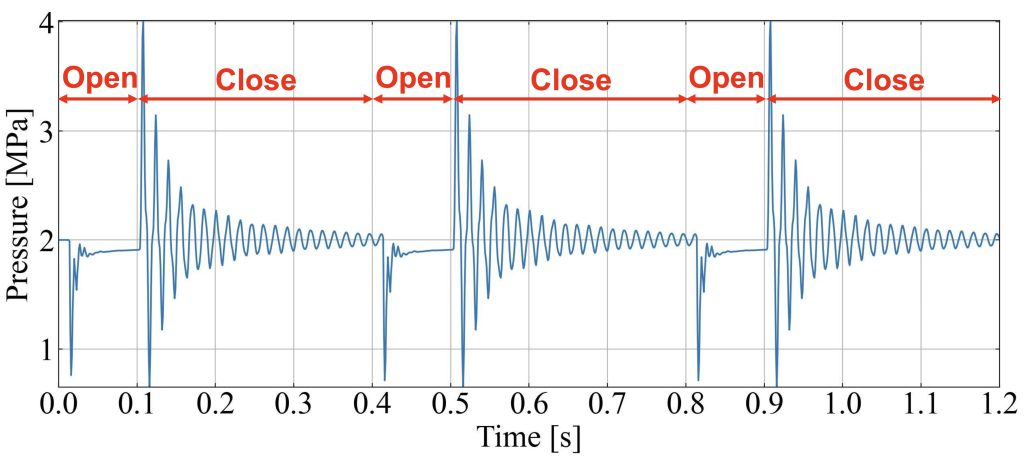

In [4]:
# Assuming all labels are carried over per chunk, triple the labels dataframe

triple_labels = pd.DataFrame(np.repeat(labels.values, 3, axis=0))
triple_labels.columns = labels.columns

y_repeated = np.repeat(y, 3)

# Break into 3 segments for each signal in training set
segments = []
for signal in x_train:
    for start_time in [0, 400, 800]:
        segment = signal[start_time : start_time + 400, :]
        segments.append(segment)

x_train_segmented = np.array(segments)

# Break into 3 segments for each signal in testing set
segments = []
for signal in x_test:
    for start_time in [0, 400, 800]:
        segment = signal[start_time : start_time + 400, :]
        segments.append(segment)
        
x_test_segmented = np.array(segments)

## Perform discrete wavelet transform (DWT) with the db1 (Haar) wavelet
Below, we will flatten all pressure signals into a single (noisier) signal, and use the Haar wavelet for a multilevel decomposition using PyWavelets. In discrete wavelet transform, the "energy" of the high-frequency components are returned in the detail coefficients (CD), whereas the low-frequency content is stored in the approximation coefficients (CA). We will do a full decomposition of 11 levels and concatenate the wavelet coefficients together, which are returned in a list that looks like this:

$$\begin{bmatrix}
CA_{11} & CD_{11} & CD_{10} & CD_9 & CD_8 & CD_7 & CD_6 & CD_5 & CD_4 & CD_3 & CD_2 & CD_1
\end{bmatrix}$$

The coefficients relate to each of the frequency sub-bands as follows:

$$\begin{align*}
CD_N: \left[\dfrac{F_s}{2^{N+1}}, 2\dfrac{F_s}{2^{N+1}} \right)\\
CA_N: \left[0, \dfrac{F_s}{2^{N+1}} \right)
\end{align*}$$

- $CD_1$: [250 Hz, 500 Hz)
- $CD_2$: [125 Hz, 250 Hz)
- $CD_3$: [62.5 Hz, 125 Hz) 
- $CD_4$: [31.25 Hz, 62.5 Hz)
- $CD_5$: [15.625 Hz, 31.25 Hz)
- $CD_6$: [7.8125 Hz, 15.625 Hz)
- $CD_7$: [3.90625 Hz, 7.8125 Hz)
- $CD_8$: [1.953 Hz, 3.90625 Hz)
- $CD_9$: [0.9766 Hz, 1.953 Hz)
- $CD_{10}$: [0.488 Hz, 0.9766 Hz)
- $CD_{11}$: [0.244 Hz, 0.488 Hz)
- $CA_{11}$: [0 Hz, 0.244 Hz)

In [5]:
# Flatten all 7 pressure signals and perform DWT for training and testing
x_train_reshaped = x_train_segmented.reshape(len(x_train_segmented), -1)
x_train_dwt = np.concatenate(wavedec(x_train_reshaped, 'db1')[:12], axis=-1)

x_test_reshaped = x_test_segmented.reshape(len(x_test_segmented), -1)
x_test_dwt = np.concatenate(wavedec(x_test_reshaped, 'db1')[:12], axis=-1)

## Violin Plots of DWT Coefficients
We will make some violin plots to illustrate how the DWT coefficients look like for the 3 major classes in the training set (normal, solenoid valve faults, and bubble faults).

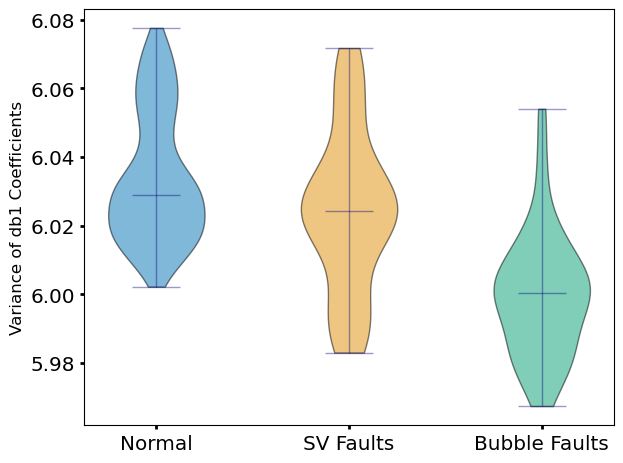

In [6]:
mpl.style.use('tableau-colorblind10')

mpl.rcParams.update({'lines.linewidth':2,
                     'lines.markersize':10,
                     'lines.markeredgewidth':1.0,
                     'axes.labelsize':16,
                     'axes.titlesize':16,
                     'legend.fontsize':14,
                     'legend.numpoints':1,
                     'lines.markersize':10,
                     'xtick.labelsize':'large',
                     'xtick.major.size':3.0,
                     'xtick.minor.size':4.0,
                     'xtick.major.width':2,
                     'xtick.minor.width':1.5,
                     'ytick.labelsize':'large',
                     'ytick.major.size':3.0,
                     'ytick.major.width':2,
                     'font.size': 12,
                     #'font.family':'Helvetica'
                    })


# Aggregating DWT coefficient data for three subgroups: normal, SV faults, bubble faults
# Labels are referencing indices from labels.csv (tripled due to our earlier pre-processing)
# First 105 are normal, next 48 are SV faults, last 24 are bubble anomalies
normal_coeffs = np.var(x_train_dwt[:105*3, :], axis=1)
sv_coeffs = np.var(x_train_dwt[105*3:153*3, :], axis=1)
bubble_coeffs = np.var(x_train_dwt[153*3:, :], axis=1)

# Combine the data into a list
violin_data = [normal_coeffs, sv_coeffs, bubble_coeffs]

# Set the labels for the examples
violin_labels = ['Normal', 'SV Faults', 'Bubble Faults']

# Create a violin plot
color_palette = sns.color_palette("colorblind", n_colors=len(violin_data))

fig, ax = plt.subplots()

# Create a violin plot with distinct colors
violins = ax.violinplot(violin_data, showmedians=True, showextrema=True, positions=np.arange(1, len(violin_data) + 1))

# Customize the colors
for pc, color in zip(violins['bodies'], color_palette):
    pc.set_facecolor(color)
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)
    
for partname in ('cbars','cmins','cmaxes','cmedians'):
    vp = violins[partname]
    vp.set_edgecolor('navy')
    vp.set_linewidth(1)
    vp.set_alpha(0.4)

# Customize the plot
ax.set_xticks(np.arange(1, len(violin_labels) + 1), violin_labels)
ax.set_ylabel('Variance of db1 Coefficients')

plt.tight_layout()
plt.show()


## Benchmarking 3-Class Classification
The following algorithms will be compared on the training set for 3-class classification:
- Random Forest
- XGBoost 
- Logistic Regression
- Support Vector Machine
- Decision Tree 
- Gradient Boosting 
- k-Nearest Neighbors
- Naive Bayes
- Artificial Neural Network

We can choose to execute these tasks out-of-distribution (e.g., using data from Spacecraft 2 and 3 to predict Spacecraft 1, which is representative of half of the testing set). This can give us an idea of how well the models generalize for unseen data sampled from a different distribution. If out_of_distribution is False, then we mix all the data and do a randomized hold-out validation set (85%-15% training-validation split). Note: ignore any warning messages on convergence, this tends to happen for logistic regression when the number of iterations is kept to its default setting.

In [7]:
# Standardize feature set for machine learning classification
stdscaler = StandardScaler()
x_train_features_std = stdscaler.fit_transform(x_train_dwt)
x_test_features_std = stdscaler.transform(x_test_dwt)

In [8]:
# (name, CodeName, params)
models = [("Random Forest",RandomForestClassifier, {} ),
          ("XGBoost", XGBClassifier, {}),
          ("LogisticRegression", LogisticRegression,{}),
          ("SVM", SVC,{}),
          ("Decision Tree", DecisionTreeClassifier,{}),
          ("Gradient boosting", GradientBoostingClassifier,{}),
          ("k-Nearest Neighbors", KNeighborsClassifier,{}),
          ("Naive Bayes", GaussianNB, {}),
          ("Neural Net", MLPClassifier, {}),
          ]

do_out_of_distribution = True

if do_out_of_distribution:
    train_idx = triple_labels['Spacecraft#'] != 1
    test_idx = triple_labels['Spacecraft#'] == 1

    X_train = x_train_features_std[train_idx,:]
    y_train = y_repeated[train_idx] 
    X_test = x_train_features_std[test_idx,:]
    y_test = y_repeated[test_idx]
else:
    X_train, X_test, y_train, y_test = train_test_split(x_train_features_std, y_repeated, test_size=0.15, random_state=41)
    



benchmarking_cols = {'method': [], 'accuracy': []}
benchmarking = pd.DataFrame(benchmarking_cols)


for i in range(len(models)):
    benchmark_model = models[i][1](**models[i][2])
    benchmark_model.fit(X_train, y_train)
    y_pred = benchmark_model.predict(X_test)
    # Assuming you have y_true (true labels) and y_pred (predicted labels)
    accuracy = accuracy_score(y_test, y_pred)

    new_row = pd.DataFrame({'method': [models[i][0]], 'accuracy': [accuracy]})
    benchmarking = pd.concat([benchmarking,new_row])


pd.set_option('display.float_format', '{:.2f}'.format)

print("Out of distribution?:", do_out_of_distribution)
benchmarking_out_distr = benchmarking.rename(columns = {"accuracy":"out-distr. acc"})
benchmarking

Out of distribution?: True


,method,accuracy
0,Random Forest,0.99
0,XGBoost,0.99
0,LogisticRegression,0.90
0,SVM,0.84
0,Decision Tree,0.93
0,Gradient boosting,0.99
0,k-Nearest Neighbors,0.80
0,Naive Bayes,0.41
0,Neural Net,0.87


# Semi-Supervised Anomaly Detection
Let's try PCA-based anomaly scoring learned from the training set -- treating all of it as a "known" class -- to identify the most likely new / anomalous patterns in the test set that are not represented in the training set. We will use 50 major principal components for this approach.

PCA anomaly scoring equation:
$$ \sum \limits_{i=1}^p \dfrac{y_i^2}{\lambda_i} = \dfrac{y_1 ^2}{\lambda_1} + \dfrac{y_2 ^2}{\lambda_2} + \dots + \dfrac{y_p ^2}{\lambda_p}$$

The higher the score, the more it diverges from the rest of the dataset.

In [9]:
pca_model = PCA(n_components=50) #can't use all components here bc of the huge dimensionality
x_train_pca = pca_model.fit_transform(x_train_features_std)
x_test_pca = pca_model.transform(x_test_features_std)

anomaly_scores_train = np.sum( (x_train_pca ** 2) / pca_model.explained_variance_, axis=1)
anomaly_scores_test = np.sum( (x_test_pca ** 2) / pca_model.explained_variance_, axis=1)

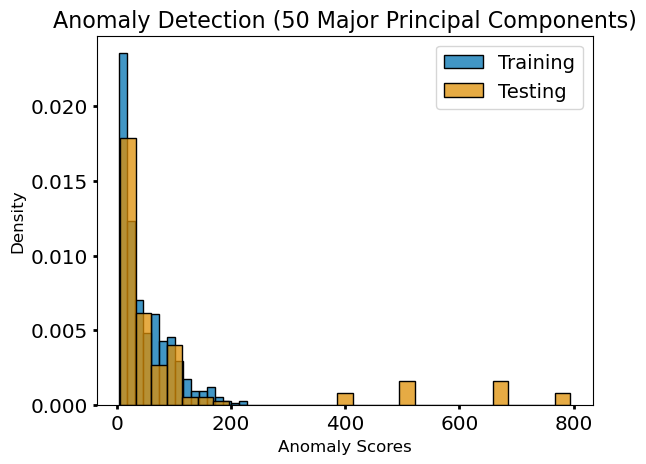

In [10]:
sns.histplot(data=anomaly_scores_train, color=color_palette[0], label='Training', stat='density')
sns.histplot(data=anomaly_scores_test, color=color_palette[1], label='Testing', stat='density')

# Add labels and legend
plt.xlabel('Anomaly Scores')
plt.ylabel('Density')
plt.title('Anomaly Detection (50 Major Principal Components)')
plt.legend()

# Show the plot
plt.show()

In [11]:
# Extract anomaly indices by examining highest scores
# From our analysis, we predict 6 unknown anomalies present in the testing set (18 segmented samples)
anomaly_idxs = np.argsort(anomaly_scores_test)[::-1]
anomaly_idxs = np.unique(np.floor(anomaly_idxs / 3)[:18]).astype(int)

# Create Test Set Predictions (Cases 178-223)
We will now construct a dataframe of Cases 178-223, the 46 signals in the testing set. We will initialize this in the format from the PHM AP 2023 Data Challenge:

- Column 1 "idx": Case number
- Column 2 "task1": Binary classification (0 for normal, 1 for abnormal)
- Column 3 "task2": Fault Classification (0 for normal, 1 for unknown anomaly, 2 for bubble fault, 3 for SV fault)
- Column 4 "task3": Bubble fault location (1-8 possible locations, 0 if not a bubble fault)
- Column 5 "task4": SV fault location (1-4 possible locations, 0 if not a SV fault)
- Column 6 "task5": SV opening ratio percentage (100 for normal, between 0 and 100 for SV faults)

In [12]:
# Initialize test submission dataframe
case_numbers = range(178, 224)

initial_preds = np.zeros(len(x_test)).astype(np.int64)
initial_sv_preds = 100*np.ones(len(x_test)).astype(np.int64)

initial_data = {'id': case_numbers, 'task1': initial_preds, 
     'task2': initial_preds, 'task3': initial_preds,
     'task4': initial_preds, 'task5': initial_sv_preds}

test_cases_df = pd.DataFrame(data=initial_data, dtype=np.int64)

# Assign unknown anomalies in respective columns
unknowns = initial_preds
unknowns[anomaly_idxs[:6]] = 1 # setting 6 unknown anomalies

test_cases_df['task1'] = unknowns
test_cases_df['task2'] = unknowns

In [13]:
# Filter out unknowns for rest of analysis
test_cases_filtered_df = test_cases_df[test_cases_df['task2'] != 1]

# Will merge unknowns_df back in final submission
unknowns_df = test_cases_df[test_cases_df['task2'] == 1]
unknowns_df # prints out unknown anomalies

,id,task1,task2,task3,task4,task5
6,184,1,1,0,0,100
14,192,1,1,0,0,100
22,200,1,1,0,0,100
29,207,1,1,0,0,100
40,218,1,1,0,0,100
44,222,1,1,0,0,100


# High-Level Predictions on Test Set (Normal = 0, Solenoid = 1, Bubble = 2)
Now that we have filtered out the unknown anomalies, we can proceed with the next task: high-level classifications for the known fault types. For the purpose of our code here, SV faults have a class label of 1, but we will need to correct this for the final submission dataframe (where SV faults have a label of 3 in "task2"). First, we will need to triple our filtered test cases dataframe to process it with the rest of the analysis. We will then use a Random Forest classifier to make these predictions. 

In [14]:
# Triple the test dataframe
triple_df = pd.DataFrame(np.repeat(test_cases_filtered_df.values, 3, axis=0))
triple_df.columns = test_cases_filtered_df.columns

# Filter out unknown anomalies from corrupting the test feature set
# We use the 'task2' column (where it equals 1) for this
x_test_features_filtered = x_test_features_std[np.repeat(test_cases_df['task2'] != 1, 3)]

clf = RandomForestClassifier()
clf.fit(x_train_features_std, y_repeated)
yhat_test = clf.predict(x_test_features_filtered)

# Fill in tripled df with the test predictions
triple_df['task1'] = (yhat_test >= 1).astype(int) # for binary (abnormal is 1)
triple_df['task2'] = yhat_test # for multi-class

#Correct SV faults from yhat_test (remapping all the 1's to equal 3)
triple_df['task2'] = triple_df['task2'].map({0:0, 1:3, 2:2})

Interestingly, we see some cases where there is segment-to-segment disagreement in the multi-class classification task. Notably, Cases 199, 205, 211 tend to be predicted as SV faults according to their first segments, but are predicted as normal for the latter two segments. This seems to be a consistent finding for the borderline SV cases in our analysis. What we will do is to "correct" this dataframe by applying the following rule: if any of the 3 segments is predicted as a SV fault, then they will all carry this prediction (so that their indices will still be carried forward for the subsequent location + ratio analysis).

In [15]:
triple_corrected_df = triple_df

# iterating through all test cases
for idx in range(178,224):
    # temporary table of the 3 segments per case: check if any of them have 'task2' = 3
    temp_table = triple_corrected_df[triple_df['id'] == idx]
    if 3 in temp_table['task2'].values:
        # repeat vals for all 3 segments
        vals = np.array([idx, 1, 3, 0, 0, 100])
        triple_corrected_df[triple_df['id'] == idx] = np.tile(vals, (3, 1))

# Print what we have so far 
print(triple_corrected_df.to_string())

      id  task1  task2  task3  task4  task5
0    178      1      2      0      0    100
1    178      1      2      0      0    100
2    178      1      2      0      0    100
3    179      1      3      0      0    100
4    179      1      3      0      0    100
5    179      1      3      0      0    100
6    180      0      0      0      0    100
7    180      0      0      0      0    100
8    180      0      0      0      0    100
9    181      1      3      0      0    100
10   181      1      3      0      0    100
11   181      1      3      0      0    100
12   182      0      0      0      0    100
13   182      0      0      0      0    100
14   182      0      0      0      0    100
15   183      0      0      0      0    100
16   183      0      0      0      0    100
17   183      0      0      0      0    100
18   185      0      0      0      0    100
19   185      0      0      0      0    100
20   185      0      0      0      0    100
21   186      1      2      0   

# Solenoid Location Predictions
First, we will evaluate how well we predict solenoid valve faults for spacecraft 1 using training dataset only. Here, it is important to note that the "test" variable names are referring to a hold-out validation set. Once again, we can toggle on/off out-of-distribution validation versus a random hold-out set. We will use a cross-validated logistic regression (<b>penalized for sparsity</b>) for improved accuracy.

In [16]:
do_out_of_distribution = True

if do_out_of_distribution == True:
    train_idxs = (triple_labels['Condition'] == 1) & (triple_labels['Spacecraft#'] != 1)
    test_idxs = (triple_labels['Condition'] == 1) & (triple_labels['Spacecraft#'] == 1)

    sv_train_df = triple_labels[train_idxs]
    x_train_sv = x_train_features_std[train_idxs, :]
    y_train_sv = np.argmin(sv_train_df.iloc[:, 3:7].values, axis=1)

    sv_test_df = triple_labels[test_idxs]
    x_test_sv = x_train_features_std[test_idxs, :]
    y_test_sv = np.argmin(sv_test_df.iloc[:, 3:7].values, axis=1)

else:
    train_idxs = triple_labels['Condition'] == 1
    sv_train_df = triple_labels[train_idxs]
    
    x_sv = x_train_features_std[train_idxs, :]
    y_sv = np.argmin(sv_train_df.iloc[:, 3:7].values, axis=1)
    x_train_sv, x_test_sv, y_train_sv, y_test_sv = train_test_split(x_sv, y_sv, test_size=0.3)

In [17]:
# Classification results for SV fault locations
clf = LogisticRegressionCV(penalty='l1', solver='liblinear', max_iter=2000)
clf.fit(x_train_sv, y_train_sv)
yhat_test_sv = clf.predict(x_test_sv)

print(classification_report(y_test_sv+1, yhat_test_sv+1))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00        12
           4       1.00      1.00      1.00        12

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48



Now that we have demonstrated success in the training set, let's train the LogisticRegressionCV model on the entire training dataset's examples of SV faults to make our predictions on the testing set.

In [18]:
# Index the solenoid training and predicted ones in test
train_idxs = triple_labels['Condition'] == 1 # we only want to use SV faults
test_idxs = triple_corrected_df['task2'] == 3

x_train_sv = x_train_features_std[train_idxs, :]
x_test_sv = x_test_features_filtered[test_idxs, :]

# Prepare labels
sv_train_df = triple_labels[train_idxs]
y_train_sv = np.argmin(sv_train_df.iloc[:, 3:7].values, axis=1) # gives the location of the SV faults

# Make Predictions
clf = LogisticRegressionCV(penalty='l1', solver='liblinear')
clf.fit(x_train_sv, y_train_sv)
yhat_test_sv = clf.predict(x_test_sv) + 1 # obtains SV locations without zero indexing

# Print number of nonzero terms
print('Number of nonzero coefficients (not counting intercept): {}'.format(np.sum(clf.coef_ != 0)))

Number of nonzero coefficients (not counting intercept): 63


In [19]:
triple_corrected_df['task4'][test_idxs] = yhat_test_sv

# Print what we have so far
print(triple_corrected_df.to_string())

      id  task1  task2  task3  task4  task5
0    178      1      2      0      0    100
1    178      1      2      0      0    100
2    178      1      2      0      0    100
3    179      1      3      0      2    100
4    179      1      3      0      2    100
5    179      1      3      0      2    100
6    180      0      0      0      0    100
7    180      0      0      0      0    100
8    180      0      0      0      0    100
9    181      1      3      0      4    100
10   181      1      3      0      4    100
11   181      1      3      0      4    100
12   182      0      0      0      0    100
13   182      0      0      0      0    100
14   182      0      0      0      0    100
15   183      0      0      0      0    100
16   183      0      0      0      0    100
17   183      0      0      0      0    100
18   185      0      0      0      0    100
19   185      0      0      0      0    100
20   185      0      0      0      0    100
21   186      1      2      0   

# Solenoid Ratio Regression Prediction

Once again, we will first evaluate the performance on the training set with a hold-out validation set (out-of-distribution toggle still available).

In [20]:
do_out_of_distribution = True

if do_out_of_distribution == True:
    train_idxs = (triple_labels['Condition'] == 1) & (triple_labels['Spacecraft#'] != 1)
    test_idxs = (triple_labels['Condition'] == 1) & (triple_labels['Spacecraft#'] == 1)

    sv_train_df = triple_labels[train_idxs]
    x_train_ratio = x_train_features_std[train_idxs, :]
    y_train_ratio = np.min(sv_train_df.iloc[:, 3:7].values, axis=1)

    sv_test_df = triple_labels[test_idxs]
    x_test_ratio = x_train_features_std[test_idxs, :]
    y_test_ratio = np.min(sv_test_df.iloc[:, 3:7].values, axis=1)

else:
    train_idxs = triple_labels['Condition'] == 1
    sv_train_df = triple_labels[train_idxs]
    
    x_ratio = x_train_features_std[train_idxs, :]
    y_ratio = np.min(sv_train_df.iloc[:, 3:7].values, axis=1)
    x_train_ratio, x_test_ratio, y_train_ratio, y_test_ratio = train_test_split(x_ratio, y_ratio, test_size=0.10, random_state=42)

## Plots for SV Ratio Regression
We will include some interesting regression plots for the hardest task, predicting the SV ratios. First, we will have a comparison between LASSO and XGBoost based on training set performance. Then, we will show the impact the regularization has on the sparsity of the model as well as its prediction accuracy. Ignore all warning messages on convergence as before.

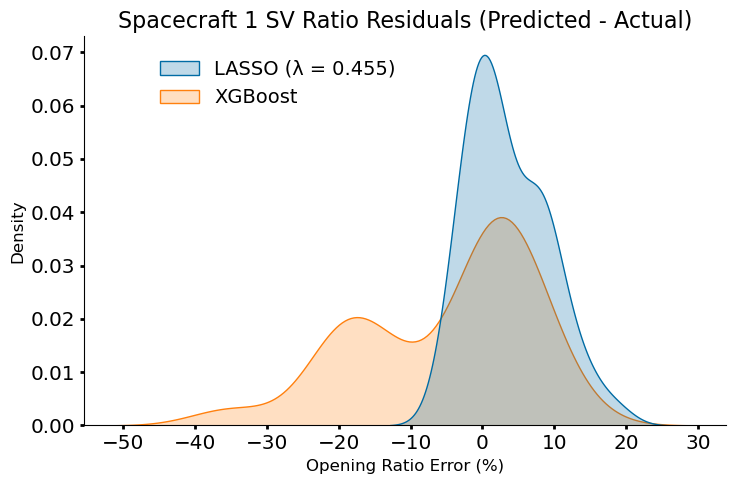

In [21]:
lasso_regressor = LassoCV(max_iter=3000)
lasso_regressor.fit(x_train_ratio, y_train_ratio)
lasso_yhat = lasso_regressor.predict(x_test_ratio)
lasso_residuals = lasso_yhat - y_test_ratio

xgb_regressor = XGBRegressor()
xgb_regressor.fit(x_train_ratio, y_train_ratio)
xgb_yhat = xgb_regressor.predict(x_test_ratio)
xgb_residuals = xgb_yhat - y_test_ratio

# put in dataframe for seaborn plot
residual_df = pd.DataFrame({'LASSO (λ = {:.3f})'.format(lasso_regressor.alpha_): lasso_residuals,
                           'XGBoost': xgb_residuals})

residual_plot = sns.displot(data=residual_df, kind='kde',
                            color=[color_palette[0], color_palette[1]], common_norm=False, fill=True)

# Add labels and legend
plt.xlabel('Opening Ratio Error (%)')
plt.ylabel('Density')
plt.title('Spacecraft 1 SV Ratio Residuals (Predicted - Actual)')
sns.move_legend(residual_plot, "upper left", bbox_to_anchor=(0.2, 0.9))

# Show the plot
plt.tight_layout()
plt.show()

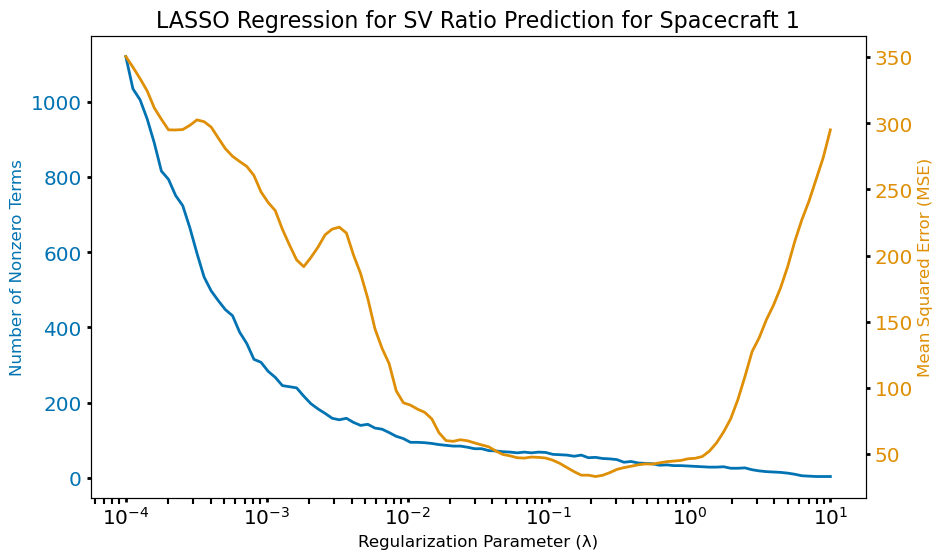

In [22]:
lambdas = np.logspace(-4, 1, 100)

# Initialize lists to store results
nonzero_terms = []
mse_values = []

# Iterate through different alpha values
for λ in lambdas:
    lasso = Lasso(alpha=λ, max_iter=3000)
    lasso.fit(x_train_ratio, y_train_ratio)
    y_pred = lasso.predict(x_test_ratio)
    
    # Calculate the number of nonzero terms in the coefficients
    num_nonzero = np.sum(lasso.coef_ != 0)
    
    # Calculate MSE and store results
    mse = np.mean((y_test_ratio - y_pred) ** 2)
    nonzero_terms.append(num_nonzero)
    mse_values.append(mse)

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the number of nonzero terms on the first y-axis
ax1.plot(lambdas, nonzero_terms, color=color_palette[0], label='Nonzero Terms', linewidth=2)
ax1.set_xlabel('Regularization Parameter (λ)')
ax1.set_ylabel('Number of Nonzero Terms', color=color_palette[0])
ax1.tick_params(axis='y', labelcolor=color_palette[0])
ax1.set_xscale('log')

# Create a second y-axis
ax2 = ax1.twinx()

# Plot the MSE on the second y-axis
ax2.plot(lambdas, mse_values, color=color_palette[1], label='MSE', linewidth=2)
ax2.set_ylabel('Mean Squared Error (MSE)', color=color_palette[1])
ax2.tick_params(axis='y', labelcolor=color_palette[1])

# Title and grid
plt.title('LASSO Regression for SV Ratio Prediction for Spacecraft 1')

# Show the plot
plt.show()

Now we will use the entire training set to predict the SV ratios for the testing set.

In [23]:
# Index the solenoid training and predicted ones in test
train_idxs = triple_labels['Condition'] == 1
test_idxs = triple_corrected_df['task2'] == 3

x_train_ratio = x_train_features_std[train_idxs, :]
x_test_ratio = x_test_features_filtered[test_idxs, :]

# Prepare labels
sv_train_df = triple_labels[train_idxs]
y_train_ratio = np.min(sv_train_df.iloc[:, 3:7], axis=1)

# Make Predictions
regressor = LassoCV(max_iter=2000)
regressor.fit(x_train_ratio, y_train_ratio)
yhat_test_ratio = regressor.predict(x_test_ratio)

# Print number of nonzero terms
print('Number of nonzero coefficients (not counting intercept): {}'.format(np.sum(regressor.coef_ != 0)))

Number of nonzero coefficients (not counting intercept): 52


In [24]:
triple_corrected_df['task5'][test_idxs] = yhat_test_ratio

# Print what we have so far
print(triple_corrected_df.to_string())

      id  task1  task2  task3  task4  task5
0    178      1      2      0      0 100.00
1    178      1      2      0      0 100.00
2    178      1      2      0      0 100.00
3    179      1      3      0      2  21.96
4    179      1      3      0      2  19.84
5    179      1      3      0      2  19.70
6    180      0      0      0      0 100.00
7    180      0      0      0      0 100.00
8    180      0      0      0      0 100.00
9    181      1      3      0      4  71.42
10   181      1      3      0      4  72.09
11   181      1      3      0      4  71.80
12   182      0      0      0      0 100.00
13   182      0      0      0      0 100.00
14   182      0      0      0      0 100.00
15   183      0      0      0      0 100.00
16   183      0      0      0      0 100.00
17   183      0      0      0      0 100.00
18   185      0      0      0      0 100.00
19   185      0      0      0      0 100.00
20   185      0      0      0      0 100.00
21   186      1      2      0   

# Bubble Location Predictions

First, we will evaluate how well we do on Spacecraft 1 again, and then proceed to make predictions on the testing set. We will use the fact that the last 24 samples on labels.csv are the bubble faults below.

In [25]:
# Get bubble faults from labels
df_bubble = triple_labels[-24*3:].iloc[:, 7:]
df_bubble = df_bubble.replace({'No': 0, 'Yes': 1})
x_train_bubble = x_train_features_std[-24*3:, :]
y_train_bubble = np.argmax(df_bubble.values, axis=1) 

#Use Spacecraft 2 and 3 to predict Spacecraft 1
x_test_bubble = x_train_bubble[:8*3, :]
y_test_bubble = y_train_bubble[:8*3] 
x_train_bubble = x_train_bubble[-16*3:, :]
y_train_bubble = y_train_bubble[-16*3:] 

clf = LogisticRegressionCV(penalty='l1', solver='liblinear')
clf.fit(x_train_bubble, y_train_bubble)
yhat_test_bubble = clf.predict(x_test_bubble)

print(classification_report(y_test_bubble + 1, yhat_test_bubble + 1))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



In [26]:
# Index the bubble training and predicted ones in test
train_idxs = triple_labels['Condition'] == 2
test_idxs = triple_corrected_df['task2'] == 2

x_train_bubble = x_train_features_std[train_idxs, :]
x_test_bubble = x_test_features_filtered[test_idxs, :]

# Prepare labels
df_bubble = triple_labels[-24*3:].iloc[:, 7:] 
df_bubble = df_bubble.replace({'No': 0, 'Yes': 1})
y_train_bubble = np.argmax(df_bubble.values, axis=1)

clf = LogisticRegressionCV(penalty='l1', solver='liblinear')
clf.fit(x_train_bubble, y_train_bubble)
yhat_test_bubble = clf.predict(x_test_bubble) + 1# obtains bubble locations without zero indexing

# Print number of nonzero terms
print('Number of nonzero coefficients (not counting intercept): {}'.format(np.sum(clf.coef_ != 0)))

Number of nonzero coefficients (not counting intercept): 65


In [27]:
# Segment-wise predictions
triple_corrected_df['task3'][test_idxs] = yhat_test_bubble
print(triple_corrected_df.to_string())

      id  task1  task2  task3  task4  task5
0    178      1      2      2      0 100.00
1    178      1      2      2      0 100.00
2    178      1      2      2      0 100.00
3    179      1      3      0      2  21.96
4    179      1      3      0      2  19.84
5    179      1      3      0      2  19.70
6    180      0      0      0      0 100.00
7    180      0      0      0      0 100.00
8    180      0      0      0      0 100.00
9    181      1      3      0      4  71.42
10   181      1      3      0      4  72.09
11   181      1      3      0      4  71.80
12   182      0      0      0      0 100.00
13   182      0      0      0      0 100.00
14   182      0      0      0      0 100.00
15   183      0      0      0      0 100.00
16   183      0      0      0      0 100.00
17   183      0      0      0      0 100.00
18   185      0      0      0      0 100.00
19   185      0      0      0      0 100.00
20   185      0      0      0      0 100.00
21   186      1      2      6   

In [28]:
# Making sure that the valve opening ratio predictions lie between 0 and 100
triple_corrected_df['task5'] = triple_corrected_df['task5'].apply(lambda x: min(max(x, 0), 100))
print(triple_corrected_df.to_string())

      id  task1  task2  task3  task4  task5
0    178      1      2      2      0 100.00
1    178      1      2      2      0 100.00
2    178      1      2      2      0 100.00
3    179      1      3      0      2  21.96
4    179      1      3      0      2  19.84
5    179      1      3      0      2  19.70
6    180      0      0      0      0 100.00
7    180      0      0      0      0 100.00
8    180      0      0      0      0 100.00
9    181      1      3      0      4  71.42
10   181      1      3      0      4  72.09
11   181      1      3      0      4  71.80
12   182      0      0      0      0 100.00
13   182      0      0      0      0 100.00
14   182      0      0      0      0 100.00
15   183      0      0      0      0 100.00
16   183      0      0      0      0 100.00
17   183      0      0      0      0 100.00
18   185      0      0      0      0 100.00
19   185      0      0      0      0 100.00
20   185      0      0      0      0 100.00
21   186      1      2      6   

In [29]:
# Creating the final submission object
final_df = pd.DataFrame(columns = triple_corrected_df.columns)

# We utilized the 1st segment's predictions
# NOTE: One puzzling feature of our analysis regards when our models’ predictions for each segment of the data
# were in disagreement for the faulty solenoid valve location. We learnt from the data that whenever these
# disagreements happened, the 1st segment was disproportionately more diagnostic and we followed its predictions.
# This is an intriguing result that we plan on exploring further in a follow up paper.
r = 0
for i in triple_corrected_df['id'].unique():
    buffer = triple_corrected_df[triple_corrected_df['id'] == i]
    final_df.loc[r] = list(buffer.iloc[0,:])
    if buffer.iloc[0,2] == 3:
        final_df['task5'][r] = np.mean(buffer['task5'])
    r += 1

# Making sure all of the tasks are integer values
for t in range(1,5):
    final_df['task' + str(t)] = final_df['task' + str(t)].astype(int)    
final_df['id'] = final_df['id'].astype(int)    

# Adding unknown anomalies to the final submission file and fixing pandas indices
final_df = pd.concat([final_df,unknowns_df], axis=0, ignore_index=True).sort_values(by='id')
final_df = final_df.reset_index(drop=True, inplace=False)

# Final submission file
print(final_df.to_string())

     id  task1  task2  task3  task4  task5
0   178      1      2      2      0 100.00
1   179      1      3      0      2  20.50
2   180      0      0      0      0 100.00
3   181      1      3      0      4  71.77
4   182      0      0      0      0 100.00
5   183      0      0      0      0 100.00
6   184      1      1      0      0 100.00
7   185      0      0      0      0 100.00
8   186      1      2      6      0 100.00
9   187      0      0      0      0 100.00
10  188      1      3      0      1   0.00
11  189      0      0      0      0 100.00
12  190      1      3      0      3  46.57
13  191      0      0      0      0 100.00
14  192      1      1      0      0 100.00
15  193      1      2      1      0 100.00
16  194      0      0      0      0 100.00
17  195      0      0      0      0 100.00
18  196      1      2      4      0 100.00
19  197      1      2      7      0 100.00
20  198      0      0      0      0 100.00
21  199      1      3      0      2  81.44
22  200    